In [32]:
import pandas as pd
import umap.umap_ as umap
import umap.plot
import plotly.express as px
from bokeh.plotting import show #, save, output_notebook, output_file
from sklearn.feature_extraction.text import  TfidfVectorizer
import utils

In [33]:
curated_pesticide_papers = pd.read_csv('./data/curated_pesticides.txt', sep='\t')
curated_pesticide_papers

,pmid,label,tenwise_id,pesticide
0,10234476,animal,TWPHI_00010,carbaryl
1,10369463,human,TWPHI_00003,acetamiprid
2,10583056,human,TWPHI_00010,carbaryl
3,15496540,human,TWPHI_00072,pendimethalin
4,16452832,human,TWPHI_00072,pendimethalin
...,...,...,...,...
159,39415959,animal,TWPHI_00003,acetamiprid
160,39415959,animal,TWPHI_00012,clothianidin
161,39415959,animal,TWPHI_00025,imidacloprid
162,39419870,other,TWPHI_00025,imidacloprid


In [34]:
curated_pesticide_abstracts = pd.read_csv('./data/curated_pesticides_abstracts.txt', sep='\t')
print(curated_pesticide_abstracts.shape)
curated_pesticide_abstracts.head(10)

(152, 3)


,pmid,title,abstract
0,10234476,Pesticide induced changes of nitric oxide synt...,Organic insecticides are well known neurotoxic...
1,10369463,Minor structural changes in nicotinoid insecti...,The major nitroimine insecticide imidacloprid ...
2,10583056,Evidence for double resistance to permethrin a...,A rising prevalence of head lice among school ...
3,15496540,Pesticides and lung cancer risk in the agricul...,The authors examined the relation between 50 w...
4,16452832,Pendimethalin exposure and cancer incidence am...,"Pendimethalin, a widely used herbicide, has be..."
5,16704049,Dose-additive inhibition of chinook salmon ace...,Organophosphate and carbamate insecticides are...
6,19248625,[The effect of pesticide acetamiprid on bioche...,The effects of ecological real concentration o...
7,19934164,"Time-course, dose-response, and age comparativ...",N-Methyl carbamate insecticides are reversible...
8,22361216,Effect of chronic exposure to pendimethalin on...,"In this study, the in vivo effects of chronic ..."
9,22393406,Nicotine-like effects of the neonicotinoid ins...,Acetamiprid (ACE) and imidacloprid (IMI) belon...


In [35]:
# combine and check whether the order has not been corrupted
len(curated_pesticide_papers), len(curated_pesticide_abstracts)
# this is a problem

(164, 152)

In [36]:
merged_data = curated_pesticide_abstracts.merge(
    curated_pesticide_papers,
    on='pmid'
)
# how many rows does it have?
print(merged_data.shape)
# remove duplicates
merged_data = merged_data.drop_duplicates(subset=['pmid'])
# remove rows with no abstracts
merged_data = merged_data[merged_data['abstract'].notna()] # strange that there is a paper without abstract
# how many rows does it have?
print(merged_data.shape)

(164, 6)
(151, 6)


In [37]:
utils.preprocess_text(merged_data)
merged_data.head()

,pmid,title,abstract,label,tenwise_id,pesticide,title_clean,abstract_clean
0,10234476,Pesticide induced changes of nitric oxide synt...,Organic insecticides are well known neurotoxic...,animal,TWPHI_00010,carbaryl,pesticide induced changes of nitric oxide synt...,organic insecticides are well known neurotoxic...
1,10369463,Minor structural changes in nicotinoid insecti...,The major nitroimine insecticide imidacloprid ...,human,TWPHI_00003,acetamiprid,minor structural changes in nicotinoid insecti...,the major nitroimine insecticide imidacloprid ...
2,10583056,Evidence for double resistance to permethrin a...,A rising prevalence of head lice among school ...,human,TWPHI_00010,carbaryl,evidence for double resistance to permethrin a...,a rising prevalence of head lice among school ...
3,15496540,Pesticides and lung cancer risk in the agricul...,The authors examined the relation between 50 w...,human,TWPHI_00072,pendimethalin,pesticides and lung cancer risk in the agricul...,the authors examined the relation between 50 w...
4,16452832,Pendimethalin exposure and cancer incidence am...,"Pendimethalin, a widely used herbicide, has be...",human,TWPHI_00072,pendimethalin,pendimethalin exposure and cancer incidence am...,"pendimethalin, a widely used herbicide, has be..."


In [38]:
# which labels are present
merged_data['label'].value_counts()

label
animal        48
human         42
insect        30
other         20
general        6
eco_animal     5
Name: count, dtype: int64

In [39]:
# the custom class Tokenizer can also lemmatize, and remove short words, digits and stopwords
stopwords = utils.get_stopwords(custom = {'wa', 'use', 'using', 'one', 'two', 'three', 'study'}) 
tokenizer = utils.Tokenizer(stop_words=stopwords, min_length=3)


In [40]:
vectorizer = TfidfVectorizer(tokenizer=tokenizer, max_features=2500)
word_doc_matrix = vectorizer.fit_transform(merged_data['abstract_clean'])
# check the shape of the data vectors
print(word_doc_matrix.shape)

/Users/michielnoback/opt/miniconda3/envs/nlp/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



(151, 2500)


In [41]:
%%time
embedding = umap.UMAP(n_components=2, metric='hellinger').fit(word_doc_matrix)

CPU times: user 273 ms, sys: 76.2 ms, total: 350 ms
Wall time: 146 ms


/Users/michielnoback/opt/miniconda3/envs/nlp/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [42]:
embedding.embedding_.shape

(151, 2)

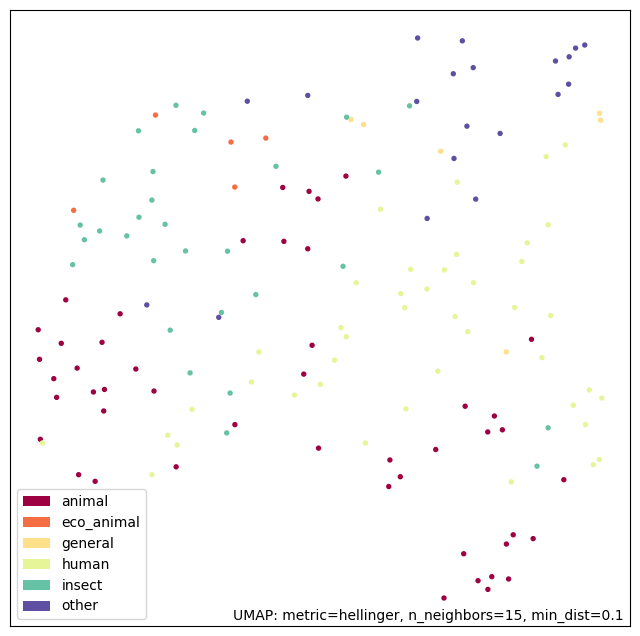

In [43]:
f = umap.plot.points(embedding, labels=merged_data['label'])

In [44]:
# For interactive plotting use
# unfortunately, this does not work anymore 
#f = umap.plot.interactive(embedding, labels=merged_data.pmid, hover_data=merged_data, point_size=3)
#show(f);

In [45]:
# convert the embedding to a pandas dataframe
embedding_df = pd.DataFrame(embedding.embedding_, columns=['x', 'y'])
embedding_df['label'] = merged_data['label'].values
embedding_df['pmid'] = merged_data['pmid'].values
embedding_df['title'] = merged_data['title'].values
# truncate title at 50 characters and add ellipsis
embedding_df['title'] = embedding_df['title'].str.slice(0, 50) + '...'

embedding_df

,x,y,label,pmid,title
0,-0.978746,-4.360464,animal,10234476,Pesticide induced changes of nitric oxide synt...
1,0.375309,-4.448852,human,10369463,Minor structural changes in nicotinoid insecti...
2,0.093235,-1.665698,human,10583056,Evidence for double resistance to permethrin a...
3,-1.185905,-2.766870,human,15496540,Pesticides and lung cancer risk in the agricul...
4,-1.268220,-2.981492,human,16452832,Pendimethalin exposure and cancer incidence am...
...,...,...,...,...,...
146,0.395817,-3.905762,human,39399211,Cytotoxicity induced by three commercial neoni...
147,-2.301224,-1.855916,insect,39402966,Toxicity of pesticide cocktails in amphibian l...
148,-0.493484,-4.064023,animal,39415959,Neonicotinoid pesticides: evidence of developm...
149,-0.720704,-1.500482,other,39419870,An overview on the fate and behavior of imidac...


In [46]:
# try interactive plot with plotly from scratch
fig = px.scatter(embedding_df, x='x', y='y', color='label', 
                 hover_data={'x': False, 'y': False, 'pmid': True,'title': True}) #hover_name='pmid', 
fig.update_layout({'plot_bgcolor': 'white', 'paper_bgcolor': 'white'})
fig.update_xaxes(showgrid=True, zeroline=False, gridcolor='lightgrey')
fig.update_yaxes(showgrid=True, zeroline=False, gridcolor='lightgrey')
fig.show()
#fig.show(renderer="browser")


## With the two labels: control/pesticide

In [47]:
file1 = './data/abstract_set1.txt'
file2 = './data/abstract_set2.txt'
data_selection = 'abstract_clean'
label_selection = 'label'

In [48]:
two_set_data = utils.read_abstract_data(negatives_path=file2, positives_path=file1)
utils.preprocess_text(two_set_data)
two_set_data.head()
#two_set_data.tail()


,pmid,title,abstract,label,text_label,title_clean,abstract_clean
0,29981025,Impact of Neoadjuvant Chemotherapy on Breast C...,"BACKGROUND: Breast cancer subtype, as determin...",0,control,impact of neoadjuvant chemotherapy on breast c...,"background: breast cancer subtype, as determin..."
1,29984001,Expert-Performed Endotracheal Intubation-Relat...,The aim of this study was to determine complic...,0,control,expert-performed endotracheal intubation-relat...,the aim of this study was to determine complic...
2,29988545,A case report: Addison disease caused by adren...,We report middle age man with skin hyperpigmen...,0,control,a case report: addison disease caused by adren...,we report middle age man with skin hyperpigmen...
3,29998100,An Unusual Morphological Presentation of Cutan...,Cutaneous squamous cell carcinoma (SCC) exhibi...,0,control,an unusual morphological presentation of cutan...,cutaneous squamous cell carcinoma (scc) exhibi...
4,29999256,Informing Consent: Medical Malpractice and the...,"Since the early 1990s, jurisdictions around th...",0,control,informing consent: medical malpractice and the...,"since the early 1990s, jurisdictions around th..."


In [49]:
# which have abstracts below 100 characters
two_set_data[two_set_data['abstract_clean'].str.len() < 100]

,pmid,title,abstract,label,text_label,title_clean,abstract_clean
100,30793266,['How harmful is your mania to you or others?'...,<p/>.,0,control,['how harmful is your mania to you or others?'...,<p/>.
3496,33364765,Parkinson's Disease Managing Reversible Neurod...,[This retracts the article DOI: 10.2147/NDT.S9...,0,control,parkinson's disease managing reversible neurod...,[this retracts the article doi: 10.2147/ndt.s9...
3873,35928025,Erratum: Improving Hepatitis B Vaccination Rat...,[This corrects the article DOI: 10.1097/pq9.00...,0,control,erratum: improving hepatitis b vaccination rat...,[this corrects the article doi: 10.1097/pq9.00...
4294,38539574,Correction: Bailey et al. Clinical Trials in H...,In the original publication [...].,0,control,correction: bailey et al. clinical trials in h...,in the original publication [...].


In [50]:
#remove these
two_set_data = two_set_data[two_set_data['abstract_clean'].str.len() > 100]
two_set_data.reset_index(drop=True, inplace=True)
two_set_data.tail()

,pmid,title,abstract,label,text_label,title_clean,abstract_clean
9101,39399211,Cytotoxicity induced by three commercial neoni...,Background: Neonicotinoid insecticides are use...,1,pesticide,cytotoxicity induced by three commercial neoni...,background: neonicotinoid insecticides are use...
9102,39406000,Mutations in target gene confers resistance to...,Echinochloa phyllopogon is a noxious weed that...,1,pesticide,mutations in target gene confers resistance to...,echinochloa phyllopogon is a noxious weed that...
9103,39411656,Genome-wide association study reveals the gene...,Crop resistance to herbicides is crucial for a...,1,pesticide,genome-wide association study reveals the gene...,crop resistance to herbicides is crucial for a...
9104,39411737,Serum 25 hydroxycholecalciferol in periodontit...,Background: Very few studies have examined the...,1,pesticide,serum 25 hydroxycholecalciferol in periodontit...,background: very few studies have examined the...
9105,39427538,Soybean isoflavones protect dopaminergic neuro...,Atrazine (ATR) is a broad-spectrum herbicide w...,1,pesticide,soybean isoflavones protect dopaminergic neuro...,atrazine (atr) is a broad-spectrum herbicide w...


In [51]:
vectorizer = TfidfVectorizer(tokenizer=tokenizer, max_features=2500)
two_set_word_matrix = vectorizer.fit_transform(two_set_data[data_selection])

/Users/michielnoback/opt/miniconda3/envs/nlp/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [52]:
print(two_set_word_matrix.shape)

(9106, 2500)


In [53]:
%%time
embedding2 = umap.UMAP(n_components=2, metric='hellinger').fit(two_set_word_matrix)

/Users/michielnoback/opt/miniconda3/envs/nlp/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



CPU times: user 27.4 s, sys: 209 ms, total: 27.6 s
Wall time: 4.22 s


In [54]:
embedding2.embedding_.shape

(9106, 2)

In [55]:
# convert the embedding to a pandas dataframe
embedding_df2 = pd.DataFrame(embedding2.embedding_, columns=['x', 'y'])
embedding_df2['text_label'] = two_set_data['text_label'].values
embedding_df2['pmid'] = two_set_data['pmid'].values
embedding_df2['title'] = two_set_data['title'].values
# truncate title at 50 characters and add ellipsis
embedding_df2['title'] = embedding_df2['title'].str.slice(0, 50) + '...'

embedding_df2

,x,y,text_label,pmid,title
0,9.563541,8.181702,control,29981025,Impact of Neoadjuvant Chemotherapy on Breast C...
1,10.621780,6.499861,control,29984001,Expert-Performed Endotracheal Intubation-Relat...
2,10.555040,8.337945,control,29988545,A case report: Addison disease caused by adren...
3,10.110520,8.811698,control,29998100,An Unusual Morphological Presentation of Cutan...
4,10.591952,4.748172,control,29999256,Informing Consent: Medical Malpractice and the...
...,...,...,...,...,...
9101,6.373811,7.211575,pesticide,39399211,Cytotoxicity induced by three commercial neoni...
9102,4.856653,4.434083,pesticide,39406000,Mutations in target gene confers resistance to...
9103,4.740425,4.509987,pesticide,39411656,Genome-wide association study reveals the gene...
9104,9.064481,5.259531,pesticide,39411737,Serum 25 hydroxycholecalciferol in periodontit...


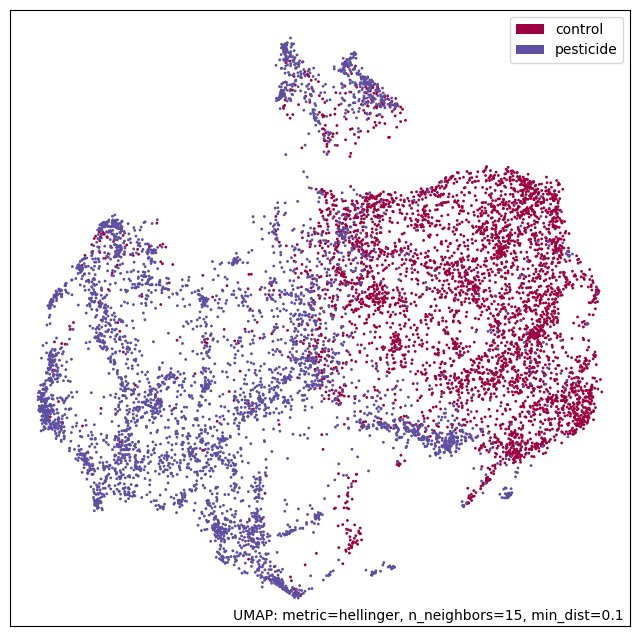

In [56]:
f = umap.plot.points(embedding2, labels=two_set_data['text_label'])

In [57]:
# For interactive plotting use; opens in browser
# f = umap.plot.interactive(embedding2, labels=two_set_data['text_label'], hover_data=two_set_data, point_size=3)
# show(f)


In [58]:
#import plotly.express as px
fig = px.scatter(embedding_df2, x='x', y='y', color='text_label', 
                 hover_data={'x': False, 'y': False, 'pmid': True,'title': True},
                 width=1000, height=1000)
fig.update_layout({'plot_bgcolor': 'white', 'paper_bgcolor': 'white'})
fig.update_xaxes(showgrid=True, zeroline=False, gridcolor='lightgrey')
fig.update_yaxes(showgrid=True, zeroline=False, gridcolor='lightgrey')
fig.update_traces(marker=dict(size=3))
fig.show()
# fig.show(renderer="browser")

### A third set
A combination of baseline data (mostly random negatives) and the positives dataset

In [59]:
train_test_papers = pd.read_csv('./data/train_test_papers.txt', sep='\t')
train_test_papers.head(5)

,pmid,title,abstract,label,text_label,title_clean,abstract_clean
0,36814389,Assessment of antioxidant and antiparkinsonian...,Oxidative stress is related to health problems...,0,control,assessment of antioxidant and antiparkinsonian...,oxidative stress is related to health problems...
1,36573268,Assessment of clinical outcomes of medicinal c...,Although pre-clinical experiments associate ca...,0,control,assessment of clinical outcomes of medicinal c...,although pre-clinical experiments associate ca...
2,40115531,Claw diseases are the dominant cause of lamene...,Lameness and mastitis are two of the most econ...,0,control,claw diseases are the dominant cause of lamene...,lameness and mastitis are two of the most econ...
3,37898890,[The interrelationship of value orientations a...,The purpose of the study is to identify relati...,0,control,[the interrelationship of value orientations a...,the purpose of the study is to identify relati...
4,36544639,PCSK9 inhibitor inclisiran for treating athero...,Proprotein convertase subtilisin/kexin type 9 ...,0,control,pcsk9 inhibitor inclisiran for treating athero...,proprotein convertase subtilisin/kexin type 9 ...


In [61]:
vectorizer = TfidfVectorizer(tokenizer=tokenizer, max_features=2500)
train_test_word_matrix = vectorizer.fit_transform(train_test_papers[data_selection])

/Users/michielnoback/opt/miniconda3/envs/nlp/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [62]:
print(train_test_word_matrix.shape)

(9679, 2500)


In [63]:
%%time
embedding3 = umap.UMAP(n_components=2, metric='hellinger').fit(train_test_word_matrix)
embedding3.embedding_.shape

/Users/michielnoback/opt/miniconda3/envs/nlp/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



CPU times: user 28.4 s, sys: 191 ms, total: 28.6 s
Wall time: 4.27 s


(9679, 2)

In [64]:
# convert the embedding to a pandas dataframe
embedding_df3 = pd.DataFrame(embedding3.embedding_, columns=['x', 'y'])
embedding_df3['text_label'] = train_test_papers['text_label'].values
embedding_df3['pmid'] = train_test_papers['pmid'].values
embedding_df3['title'] = train_test_papers['title'].values
# truncate title at 50 characters and add ellipsis
embedding_df3['title'] = embedding_df3['title'].str.slice(0, 50) + '...'

embedding_df3

,x,y,text_label,pmid,title
0,4.371961,2.964683,control,36814389,Assessment of antioxidant and antiparkinsonian...
1,0.774503,5.776216,control,36573268,Assessment of clinical outcomes of medicinal c...
2,5.849288,4.069742,control,40115531,Claw diseases are the dominant cause of lamene...
3,2.383099,4.072130,control,37898890,[The interrelationship of value orientations a...
4,1.289949,5.249300,control,36544639,PCSK9 inhibitor inclisiran for treating athero...
...,...,...,...,...,...
9674,4.580130,3.456255,pesticide,39399211,Cytotoxicity induced by three commercial neoni...
9675,6.108914,3.428087,pesticide,39406000,Mutations in target gene confers resistance to...
9676,5.974034,3.583483,pesticide,39411656,Genome-wide association study reveals the gene...
9677,1.729094,4.172667,pesticide,39411737,Serum 25 hydroxycholecalciferol in periodontit...


In [65]:
fig = px.scatter(embedding_df3, x='x', y='y', color='text_label', 
                 hover_data={'x': False, 'y': False, 'pmid': True,'title': True},
                 width=1000, height=1000)
fig.update_layout({'plot_bgcolor': 'white', 'paper_bgcolor': 'white'})
fig.update_xaxes(showgrid=True, zeroline=False, gridcolor='lightgrey')
fig.update_yaxes(showgrid=True, zeroline=False, gridcolor='lightgrey')
fig.update_traces(marker=dict(size=3))
fig.show()